# Part 2, Part 3 (evaluation) and Code for Bonus for Assignment 2, LT2326, Autumn 2021

**Name**: Max Boholm (gusbohom)

In [1]:
# MB collected all libraries at one place
import sys
import os
import numpy as np
import random
import pandas as pd

import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.optim as optim
from torch.distributions.uniform import Uniform

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [2]:
# MB. New cell
gpu_device = "cuda:1"

## 1. Loading the data, padding (based on 2.0)

Start-of-sentence (sos) and end-of-sentence (eos) tokens have been added to the data.

In [3]:
# MB added code for adding start-of-sentence (sos) and end-of-sentence (eos) tokens

sos = "#"
eos = "!"
# MB. Neither "#" nor "!" seems to be in the original data

def read_chinese_data(inputfilename):
    with open(inputfilename, "r") as inputfile:
        sentences = []
        collection_words = []
        collection_labels = []
        for line in inputfile:
            if line[0] == '#':
                continue
            columns = line.split()
            if columns == []:
                collection_words = [sos] + collection_words + [eos] # MB modified the iteration here
                collection_labels = [1] + collection_labels + [1]   # ... and here

                sentences.append((''.join(collection_words), collection_labels))
                collection_words = []
                collection_labels = []
                continue
            
            collection_words.append(columns[1])
            collection_labels += [1] + ([0] * (len(columns[1]) - 1))
            
    return sentences

In [4]:
train_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-train.conllu')
# train_sentences[0] # MB added this line

In [5]:
test_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-test.conllu')
# test_sentences[0] # MB added this line

In [6]:
def index_chars(sentences):
    megasentence = ''.join(sentences)
    char_list = set()
    for c in megasentence:
        char_list.add(c)
    char_list = [0] + list(char_list)
    return char_list, {char_list[x]:x for x in range(len(char_list))}

In [7]:
int_index, char_index = index_chars([x[0] for x in train_sentences + test_sentences])

In [8]:
def convert_sentence(sentence, index):
    return [index[x] for x in sentence]

In [9]:
def pad_lengths(sentences, max_length, padding=0):
    return [x + ([padding] * (max_length - len(x))) for x in sentences]

In [10]:
def create_dataset(x, device="cpu"):
    converted = [(convert_sentence(x1[0], char_index), x1[1]) for x1 in x]
    X, y = zip(*converted)
    lengths = [len(x2) for x2 in X]
    padded_X = pad_lengths(X, max(lengths))
    Xt = torch.LongTensor(padded_X).to(device)
    padded_y = pad_lengths(y, max(lengths), padding=-1)
    yt = torch.LongTensor(padded_y).to(device)
    lengths_t = torch.LongTensor(lengths).to(device)
    return Xt, lengths_t, yt

In [11]:
train_X_tensor, train_lengths_tensor, train_y_tensor = create_dataset(train_sentences, gpu_device)
test_X_tensor, test_lengths_tensor, test_y_tensor = create_dataset(test_sentences, gpu_device)

## 2. Packing the sequences for RNN

Cells for illstrating structure of data and performance of `pack_padded_sequence` and `pad_packed_sequence` have been removed.

## 3. Batching (based on 1.0, 1.1, 1.2)

Cells for illustrating `Batcher` have been removed. I have not done anything with `Batcher`.

In [12]:
class Batcher:
    def __init__(self, X, lengths, y, device, batch_size=50, max_iter=None):
        self.X = X
        self.lengths = lengths # We need the lengths to efficiently use the padding.
        self.y = y
        self.device = device
        self.batch_size=batch_size
        self.max_iter = max_iter
        self.curr_iter = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_iter == self.max_iter:
            raise StopIteration
        permutation = torch.randperm(self.X.size()[0], device=self.device)
        permX = self.X[permutation]
        permlengths = self.lengths[permutation]
        permy = self.y[permutation]
        splitX = torch.split(permX, self.batch_size)
        splitlengths = torch.split(permlengths, self.batch_size)
        splity = torch.split(permy, self.batch_size)
        
        self.curr_iter += 1
        return zip(splitX, splitlengths, splity)

## 4. Modeling

Cells for illustrating layers have been removed. For the `Segmenter` model I have done nothing other than adding a variable for the hidden size (`hidden_dim`); also an attribute of `Segmenter` (`self.hidden`). I have added the model `PredictNext`, which is a text generating model. Finally, I have added a third model, `DoubleObjective`, which takes a segmenter and a generator as attributes. 

A note on language model and the objective to "given a start symbol, produce a variety of sentences that terminate with a stop symbol" (part 1 of assignment 2): as designed here, a trained model, would given the same first-token (e.g. start-of-sentence token) always generate the *same* sequence *if we not added some randomness to the text generation*. The solution for doing this here is to define the initial hidden state and cell state of the LSTM by random numbers in text generation (while by zeros in training). Thus, the `PredictNext` model has a method (`initHidden`) which outputs an inital hidden state and an intial cell state by random number or zeros. 

In [13]:
# MB added variable for hidden dimension of LSTM, otherwise as before
class Segmenter(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden = hidden_dim
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, self.hidden, batch_first=True)
        self.sig1 = nn.Sigmoid()
        self.lin = nn.Linear(self.hidden, 2)
        self.softmax = nn.LogSoftmax(2)
        
    def forward(self, x, lengths):
        embs = self.emb(x)
        packed = pack_padded_sequence(embs, lengths.to("cpu"), batch_first=True, enforce_sorted=False)
        output1, _ = self.lstm(packed)
        unpacked, _ = pad_packed_sequence(output1, batch_first=True)
        output2 = self.sig1(unpacked)
        output3 = self.lin(output2)
        return self.softmax(output3)

In [14]:
# MB. New cell defining a text generator (using code from previous model definition as basis)

class PredictNext(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_dim):
        super(PredictNext, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden = hidden_dim
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, self.hidden, batch_first=True)
        self.classifier = nn.Linear(self.hidden, self.vocab_size)
        self.softmax = nn.LogSoftmax(1) # MB correct dimension?

    def forward(self, previous, h_c_states): # M.B. removed lengths
        
        bsz = previous.shape[0]
        
        emb_previous = self.emb(previous)
        output, (hidden, cell) = self.lstm(emb_previous, h_c_states)
        classification_over_vocabulary = self.classifier(hidden.reshape(bsz, self.hidden)) # MB length of input and output is 1
        classification_over_vocabulary = self.softmax(classification_over_vocabulary)
        next_one = classification_over_vocabulary.argmax(1).unsqueeze(1)
        
        return next_one, classification_over_vocabulary, (hidden, cell)
    
    def initHidden(self, batchsize, zero = True, distrib_low = -2, distrib_high = 2):
        """ MB. For initialization of hidden state and cell state of LSTMs. There are 
            two options here: zero initialization and random initialization. 
            Random initialization ranges from `distrib_low` to `distrib_high`. Here, 
            the `Uniform` function from `torch.distributions.uniform` is used for this.
            Given some experimenting `torch.rand` (which is based on a uniform 
            distribution from 0 to 1) gave only minimal variation in sentence generation
            (see below); thus, the approach chosen here. However, the default values 
            selected here are arbitrary and have little variation other than 
            `text_generator`(below) should yield (substantially) different sequences 
            when called.
        """
        
        if zero:
            init_hidden = torch.zeros(1, batchsize, self.hidden, device = gpu_device) # for unstacked lstms; see https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
            init_cell = torch.zeros(1, batchsize, self.hidden, device = gpu_device)
#         else:
#             init_hidden = torch.rand(1, batchsize, self.hidden, device = gpu_device) # for unstacked lstms; see https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
#             init_cell = torch.rand(1, batchsize, self.hidden, device = gpu_device)
        else:
            init_hidden = Uniform(distrib_low, distrib_high).sample([1, batchsize, self.hidden]).to(gpu_device)
            init_cell = Uniform(distrib_low, distrib_high).sample([1, batchsize, self.hidden]).to(gpu_device)
        
        return init_hidden, init_cell  
        

In [15]:
# MB. New cell defining a double objective model: segement and text generation

class DoubleObjective(nn.Module):
    def __init__(self, segmentation_model, text_generator):
        super(DoubleObjective, self).__init__()
        
        self.segmenter = segmentation_model
        self.generator = text_generator
        
    def forward(self, inp, lengths, h_c_states, modus):
        
        if modus == "segment":
            segmentation = self.segmenter(inp, lengths)
            return segmentation
        
        elif modus == "generate":
            next_one, classification, h_c_state = self.generator(inp, h_c_states)
            return next_one, classification, h_c_state
        
        else:
            print("ERROR: You have not provided any of the allowed modi; which are 'segment' and 'generate'.")


## 5. Training

The training loop is in large parts the same as in the original. However, modifications have been made to fit the new models and objectives (text generation and double objective of segmentaion and generation). Note that variables have been added to `train` for if it should train for segmentation (`segment`) or generation (`generate`) or both. This design enables trainging all three models (Segmenter, Generator, and DoubleObjective) with the same training function. 

In [16]:
# MB modified: 
#    one variable per line; 
#    variable for LSTM hidden dimension; 
#    adjustments to fit DoubleObjective model

def train(X, 
          lengths, 
          y, 
          vocab_size, 
          emb_size, 
          lstm_hidden_dim, 
          batch_size, 
          epochs, 
          device,
          segment=True,
          generate=True,
          model=None): 
    
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    
    if not model:
        my_segmenter = Segmenter(vocab_size, emb_size, lstm_hidden_dim).to(device)
        my_generator = PredictNext(vocab_size, emb_size, lstm_hidden_dim).to(device) 
        # MB note: embedding size and hidden dimension of LSTM could have been differentiated
        m = DoubleObjective(my_segmenter, my_generator)
    else:
        m = model
        
    loss = nn.NLLLoss(ignore_index=-1) # MB note-to-self: ignore index=-1
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    
    my_losses = []
    
    for split in b:
        tot_loss = 0
        for batch in split:
            
            optimizer.zero_grad()
            
            sentence = batch[0]
            lengths = batch[1]
            bsz = sentence.shape[0]
            seq_len = sentence.shape[1]

            total_batch_loss = 0
            
            if segment: # MB. Objective 1: segmentation
                segmentation = m(sentence, lengths, None, modus = "segment")
                trgs = batch[2]
                loss_o1 = loss(segmentation.permute(0,2,1), trgs[:, :max(lengths)])
                total_batch_loss += loss_o1
            
            if generate: # MB. Objective 2: generation
                init_hidden, init_cell = m.generator.initHidden(bsz)
                h_c_states = (init_hidden, init_cell)

                loss_o2 = 0
                the_who = sentence[:, 0].unsqueeze(1)

                for i in range(1, seq_len-1):

                    the_who, my_generation, h_c_states = m(the_who, None, h_c_states, modus = "generate")

                    target = sentence[:, i]

                    # MB a little detour for padding's sake... 
                    pad_idx = char_index[0] # MB. this the index for padding in sentences
                    target = torch.where(target == pad_idx, -1, target) # MB. https://pytorch.org/docs/stable/generated/torch.where.html
                    # MB. -1 is the padding of targets and the ignored index in loss 
                    
                    # MB. PS. I now realize that I, like the segmentation model, could have used
                    # the `train_lengths_tensor` for "ignoring" the padding in loss calculation, 
                    # but I am already past deadline and do not implement that solution here, now. 

                    loss_for_this_prediction = loss(my_generation, target)

                    loss_o2 += loss_for_this_prediction
                    
                total_batch_loss += loss_o2
            
            tot_loss += total_batch_loss
            total_batch_loss.backward()
            optimizer.step()
        
        my_losses.append(tot_loss.item())
        print("Total loss in epoch {} is {}.".format(epoch+1, tot_loss)) # MB added +1
        epoch += 1
    return m, my_losses
      

In [17]:
# MB modification: one parameter per line (easier to read)
dual_model, dual_loss_array = train(X = train_X_tensor, 
                                  lengths = train_lengths_tensor, 
                                  y = train_y_tensor, 
                                  vocab_size = len(int_index), 
                                  emb_size = 200, 
                                  lstm_hidden_dim = 150, 
                                  batch_size = 50, 
                                  epochs = 30, 
                                  device = gpu_device, 
                                  segment = True, 
                                  generate = True)

Total loss in epoch 1 is 56079.45703125.
Total loss in epoch 2 is 55343.8046875.
Total loss in epoch 3 is 54582.53515625.
Total loss in epoch 4 is 53902.53515625.
Total loss in epoch 5 is 52848.76953125.
Total loss in epoch 6 is 54087.9609375.
Total loss in epoch 7 is 53866.7890625.
Total loss in epoch 8 is 53760.53125.
Total loss in epoch 9 is 54124.8046875.
Total loss in epoch 10 is 53667.95703125.
Total loss in epoch 11 is 54089.09375.
Total loss in epoch 12 is 53829.11328125.
Total loss in epoch 13 is 54194.23828125.
Total loss in epoch 14 is 53309.33984375.
Total loss in epoch 15 is 53100.62890625.
Total loss in epoch 16 is 53139.21875.
Total loss in epoch 17 is 53492.01171875.
Total loss in epoch 18 is 53578.69921875.
Total loss in epoch 19 is 53212.41796875.
Total loss in epoch 20 is 53470.4609375.
Total loss in epoch 21 is 52687.3359375.
Total loss in epoch 22 is 53512.9921875.
Total loss in epoch 23 is 53029.51171875.
Total loss in epoch 24 is 52930.546875.
Total loss in epoch

## 6. Generation

A function `text_generator` has been defined to generate text from a trained model. Note here (as mentioned above) that initialization of hidden and cell state are set by random numbers. One each call, `text_generator` generate different sequences.

In [18]:
# MB. New cell.
def text_generator(model, prime_token = sos, max_length = 180):
    model.eval()

    rolling_stone = torch.tensor([[char_index[prime_token]]]).to(gpu_device)
    
    hidden_cell_states = model.generator.initHidden(1, zero = False)
    # MB. We need some variation to the loop in order to produce variable sentences. 
    # To use random initialization for the initial hidden and cell state of the LSTM  
    # is my suggestion for solving that. 
    
    length_of_generation = 0
    ex_nihilo = []
    end_of_sentence = False
    length_of_generation = 0
    
    while end_of_sentence == False and length_of_generation < max_length:
        rolling_stone, just_ignore_this, hidden_cell_states = model(rolling_stone, None, hidden_cell_states, modus = "generate")
        rs_as_string = str(int_index[rolling_stone.flatten()])
        if rs_as_string == eos:
            end_of_sentence = True
        else:
            ex_nihilo.append(rs_as_string)
            length_of_generation += 1

    return "".join(ex_nihilo)

In [19]:
# MB. New cell. 
text_generator(dual_model)

'10，年，，，，，，，，，，，，，，，，，，，，，，，，，，，。，，，'

In [20]:
# ... being different from:
text_generator(dual_model)

'290的年，，，，，，，，，，，，，，，，，，，，，，，，，，'

## 7. Evaluation (Part 3)

### Summary of evaluation

For the evaluation part, 
1.    Three models are called and trained: a *SegmentOnly* model, a *GenerateOnly* model and a *DualObjective* model.
2.    Functions needed for evaluation are defined for calculating accuracy and F1, for plotting, for comparing models, and for calculating perplexity.
3.    Functions are called for getting results. 

#### SegmentOnly vs. DualObjective
The evaluation show that there is (almost) no difference between SegmentOnly and DualObjective in terms of accuracy and F1, as seen in the following table (the difference is hardly significant):

|       |Acc.  |F1    |
|-------|------|------|
|DualMod|0.9297|0.9456|
|Segment|0.9303|0.946 |

Looking at loss over the epochs, SegementOnly show a smoth decent during the first 15 epochs, with smotly stable loss after that. Like SegmentOnly, DualObjective drops fast in loss during the first 5 epochs, but after that (unlike SegmentOnly), DualObjective strongly fluctates in loss for epochs after the fifth. This pattern reflects how the loss of DualObjective is clearly affected by its second objective: generation, which training seems not to be as smooth and clearly converging as the objective of segmentation. That said, the performance of DualObjective on the segmentation task is not really affected by its second objective of generation. A naive guess might perhaps have been that the first objective (segmentation) whould have been "confused" by doing another task (generation), but these results show that no such confusion emerge.

#### GenerateOnly vs. DualObjective
According to my calculations, the per-word perplexity on the text corpus for the GenerateOnly model is 739.1, while for the DualObjective model it is 866.6. According to this score, GenerateOnly is the better model of the two. The 17% increase of perplexity for the DualObjective compared with GenerateOnly, might show that the DualModel is "confused" (or perplexed) in its objective of text generation, by its first onjective of segmentation. Perhaps a general conclusion from this is that the harder task (text generation) is more affected by multiple objecitves in training than eaiser tasks are. 

*Note:* Cells for evaluation from original file has been removed. New code is presented below. 

**First**, training the other models for comparison ... 

In [21]:
# MB modification: one parameter per line (easier to read)
segment_model, segment_loss_array = train(X = train_X_tensor, 
                                  lengths = train_lengths_tensor, 
                                  y = train_y_tensor, 
                                  vocab_size = len(int_index), 
                                  emb_size = 200, 
                                  lstm_hidden_dim = 150, 
                                  batch_size = 50, 
                                  epochs = 30, 
                                  device = gpu_device, 
                                  segment = True, 
                                  generate = False) # <---- Note! (MB)

Total loss in epoch 1 is 30.40856170654297.
Total loss in epoch 2 is 16.538677215576172.
Total loss in epoch 3 is 12.491500854492188.
Total loss in epoch 4 is 9.813703536987305.
Total loss in epoch 5 is 7.852433681488037.
Total loss in epoch 6 is 6.162982940673828.
Total loss in epoch 7 is 4.762533664703369.
Total loss in epoch 8 is 3.9119274616241455.
Total loss in epoch 9 is 3.39646577835083.
Total loss in epoch 10 is 2.6431548595428467.
Total loss in epoch 11 is 1.9499913454055786.
Total loss in epoch 12 is 1.445709228515625.
Total loss in epoch 13 is 1.1824086904525757.
Total loss in epoch 14 is 1.039299488067627.
Total loss in epoch 15 is 0.9368866682052612.
Total loss in epoch 16 is 0.8839079737663269.
Total loss in epoch 17 is 1.059475064277649.
Total loss in epoch 18 is 2.036407470703125.
Total loss in epoch 19 is 2.408552408218384.
Total loss in epoch 20 is 2.3017706871032715.
Total loss in epoch 21 is 1.429935097694397.
Total loss in epoch 22 is 0.7956727743148804.
Total loss

In [22]:
# MB modification: one parameter per line (easier to read)
gen_model, gen_loss_array = train(X = train_X_tensor, 
                                  lengths = train_lengths_tensor, 
                                  y = train_y_tensor, 
                                  vocab_size = len(int_index), 
                                  emb_size = 200, 
                                  lstm_hidden_dim = 150, 
                                  batch_size = 50, 
                                  epochs = 30, 
                                  device = gpu_device, 
                                  segment = False,      # <---- Note! (MB)
                                  generate = True) 

Total loss in epoch 1 is 56617.9609375.
Total loss in epoch 2 is 54067.046875.
Total loss in epoch 3 is 54673.01171875.
Total loss in epoch 4 is 54005.46875.
Total loss in epoch 5 is 54298.84375.
Total loss in epoch 6 is 53901.91015625.
Total loss in epoch 7 is 53617.65234375.
Total loss in epoch 8 is 53953.203125.
Total loss in epoch 9 is 54138.71484375.
Total loss in epoch 10 is 53621.3046875.
Total loss in epoch 11 is 53746.8984375.
Total loss in epoch 12 is 53712.87890625.
Total loss in epoch 13 is 53183.44140625.
Total loss in epoch 14 is 53897.59375.
Total loss in epoch 15 is 52952.27734375.
Total loss in epoch 16 is 53604.08203125.
Total loss in epoch 17 is 54101.4453125.
Total loss in epoch 18 is 53124.83984375.
Total loss in epoch 19 is 53640.95703125.
Total loss in epoch 20 is 53317.4921875.
Total loss in epoch 21 is 53936.1796875.
Total loss in epoch 22 is 53695.9453125.
Total loss in epoch 23 is 53196.49609375.
Total loss in epoch 24 is 52897.18359375.
Total loss in epoch 2

**Second**, define functions for evaluation

In [23]:
# MB. New, but uses code from original
def measure(array_pred, array_truth):
    
    classes = array_truth.float()
    allpreds = array_pred.float()

    tp = sum(classes * allpreds)
    fp = sum(classes * (~allpreds.bool()).float())
    tn = sum((~classes.bool()).float() * (~allpreds.bool()).float())
    fn = sum((~classes.bool()).float() * allpreds)

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = (2 * recall * precision) / (recall + precision)
    
    return accuracy.item(), f1.item()

In [24]:
# MB. New, but uses code from the original.
def evaluate_and_compare(model1, model2):
    model1.eval()
    model2.eval()
    
    with torch.no_grad():
        raw_m1 = model1(test_X_tensor, test_lengths_tensor, None, modus="segment")
        raw_m2 = model2(test_X_tensor, test_lengths_tensor, None, modus="segment")
    
    pred1 = torch.argmax(raw_m1, 2)
    pred2 = torch.argmax(raw_m2, 2)
    
    collectpreds_m1 = []
    collectpreds_m2 = []
    collecty = []
    
    for i in range(test_X_tensor.size(0)):
        collectpreds_m1.append(pred1[i][:test_lengths_tensor[i]])
        collectpreds_m2.append(pred2[i][:test_lengths_tensor[i]])
        
        collecty.append(test_y_tensor[i][:test_lengths_tensor[i]])
    
    allpreds_m1 = torch.cat(collectpreds_m1)
    allpreds_m2 = torch.cat(collectpreds_m2)
    classes = torch.cat(collecty)
    
    accuracy_m1, f1_m1 = measure(allpreds_m1, classes)
    accuracy_m2, f1_m2 = measure(allpreds_m2, classes)
    
    my_short=4
    print("EVALUATION:")
    print(f"\tAcc.\tF1")
    print(f"Model1\t{round(accuracy_m1, my_short)}\t{round(f1_m1, my_short)}")
    print(f"Model2\t{round(accuracy_m2, my_short)}\t{round(f1_m2, my_short)}")

In [25]:
def plot_loss(loss_array):
    n_epochs = len(loss_array)
    
    x = [x for x in range(n_epochs)]
    
    plt.figure(figsize=(8,8))
    plt.plot(x, loss_array)
    plt.title("Model's loss")
    plt.show()

In [26]:
def compare_plot_loss(loss_m1, loss_m2):
    
    assert len(loss_m1) == len(loss_m2), "Different lengths!"
    
    n_epochs = len(loss_m1)
    
    x = [x for x in range(n_epochs)]
    
    plt.figure(figsize=(8,8))
    plt.plot(x, loss_m1)
    plt.plot(x, loss_m2)
    plt.title("Models' losses")
    plt.show()

In [72]:
# https://en.wikipedia.org/wiki/Perplexity
# https://stackoverflow.com/questions/61988776/how-to-calculate-perplexity-for-a-language-model-using-pytorch

def perplexity(model, corpus, length_data):
    
    NLL_func = nn.NLLLoss()
    nlls = [] # to collect losses "per word" (or here: character)
    
    for s in range(corpus.size(0)):
        h_c_states = model.generator.initHidden(1)
        sentence = test_X_tensor[s]
        
        for c in range(length_data[s] - 1): # -1; we do not predict next from eos
            character = sentence[c].unsqueeze(0) # model expects batched data
            character = character.unsqueeze(1) # model expects character from sentences
            ignore_this_one, my_generation, h_c_states = model(character, None, h_c_states, modus = "generate")
            target = sentence[c+1]
            target = target.unsqueeze(0) # as if batched
            #print(my_generation.shape)
            #print(target)
            
            nll = NLL_func(my_generation, target)
            #print(nll)
            nlls.append(nll)
    
    nlls = torch.stack(nlls)
    mean_loss = torch.mean(nlls)
    perplexity = torch.exp(mean_loss)
    
    return perplexity.item()
    

**Third**, call the functions to get evaluation statistics

In [28]:
evaluate_and_compare(dual_model, segment_model)

EVALUATION:
	Acc.	F1
Model1	0.9297	0.9456
Model2	0.9303	0.946


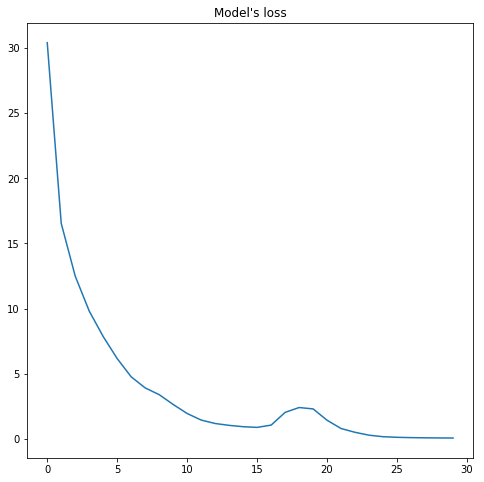

In [29]:
plot_loss(segment_loss_array)

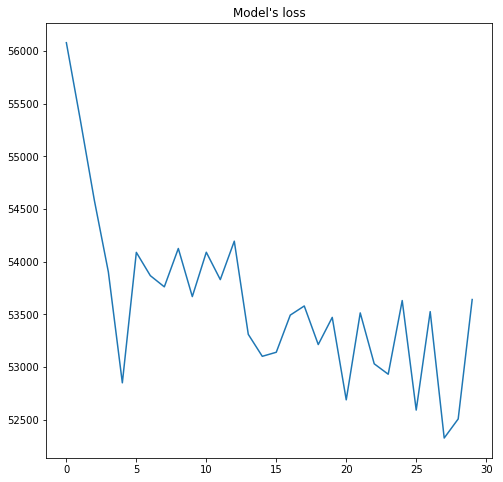

In [30]:
plot_loss(dual_loss_array)

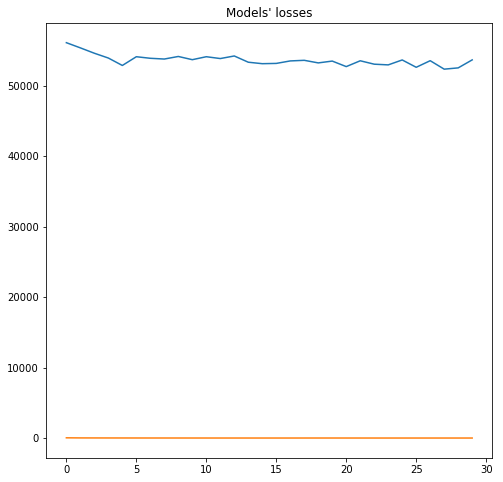

In [31]:
compare_plot_loss(dual_loss_array, segment_loss_array)

In [73]:
perplexity(dual_model, test_X_tensor, test_lengths_tensor)

866.6163940429688

In [74]:
perplexity(gen_model, test_X_tensor, test_lengths_tensor)

739.0811767578125

## 8. Bonus Part

As requested, the bonus part is discussed in a separate markdown file (`bonus_part.md`).

###  Identification of the likelihood of characters being initial in words

In [79]:
collected_char = [] # Note: "true" data, not predictions
collected_y    = []

for i in range(test_X_tensor.size(0)):
    collected_char.append(test_X_tensor[i][:test_lengths_tensor[i]])
    collected_y.append(test_y_tensor[i][:test_lengths_tensor[i]])

char_as_one = torch.cat(collected_char)
y_as_one = torch.cat(collected_y)

char_count = {char_index[char]:0 for char in int_index}
as_initial = {char_index[char]:0 for char in int_index}

for i in range(char_as_one.shape[0]):
    the_character = char_as_one[i].item()
    char_count[the_character] += 1
    as_initial[the_character] += 1

likelihood = {char:0 for char in char_count.keys()}

for char in likelihood.keys():
    if char_count[char] == 0:
        likelihood[char] = 0
    else:
        likelihood[char] = as_initial[char] / char_count[char]

### Collecting dimensions of characters and combine with their "initiality"

Note: *Initiality* is here defined as the tendency (liklihood) of a character to be the initial token of a word. 

The code for the bonus part is presented below. The analysis is discussed in `bonus_part.md`, as requested. 

In [80]:
semantics = segment_model.segmenter.emb

In [81]:
semantics.eval()

Embedding(3650, 200, padding_idx=0)

In [82]:
to_be_matrix = []
first_row = ["Character", "Initiality"]
dimensions = [f"dim{d}" for d in range(1, semantics.embedding_dim+1)]
to_be_matrix.append(first_row+dimensions)
#print(to_be_matrix)

for char in likelihood.keys():
    line = [char]
    line.append(likelihood[char])
    sem_representation = semantics(torch.tensor(char).to(gpu_device)).tolist()
    to_be_matrix.append(line + sem_representation)

df = pd.DataFrame(to_be_matrix[1:], columns = to_be_matrix[0])

In [83]:
# A version of a function I used for an assignment in LT2222, spring 2021

def reduce(matrix, dims=300):
    """ Uses scikit-learn's dimensionality reduction by singular value decomposition (SVD) to reduce a matrix. 
    See: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html"""

    char_column=np.array(matrix["Character"])
    init_column=np.array(matrix["Initiality"])    
    main_matrix=matrix.drop(labels="Character", axis=1) 
    main_matrix=matrix.drop(labels="Initiality", axis=1)

    #Reduction
    svd = TruncatedSVD(n_components=dims, n_iter=7, random_state=42) #values of n_iter and random_state from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    svd.fit(main_matrix)
    reduced_matrix=pd.DataFrame(svd.transform(main_matrix), columns = ["dim1", "dim2"])

    #Return the labels
    reduced_matrix.insert(loc=0, column="Initiality", value=init_column)
    reduced_matrix.insert(loc=0, column="Character", value=char_column)

    return reduced_matrix

In [84]:
reduced_df = reduce(df, 2)

In [85]:
def write_column(row):
    if row["Initiality"] > 0.9:
        init_cls = "High"
    elif row["Initiality"] < 0.1:
        init_cls = "Low"
    else:
        init_cls = "Intermediate"
    return init_cls

reduced_df["Init_Cls"] = df.apply(write_column, axis=1)

In [86]:
reduced_df

,Character,Initiality,dim1,dim2,Init_Cls
0,0,0.0,0.000000,0.000000,Low
1,1,1.0,0.999961,-0.797976,High
2,2,1.0,2.000082,-0.285168,High
3,3,1.0,2.999933,-1.486627,High
4,4,0.0,4.000510,-2.904642,Low
...,...,...,...,...,...
3645,3645,0.0,3644.999964,1.157093,Low
3646,3646,1.0,3645.999761,1.730492,High
3647,3647,0.0,3647.000098,1.453438,Low
3648,3648,1.0,3647.999764,1.641868,High


### Analysis

#### Is there any correlation of Initiality and Dimension 1 or Dimension 2? 
**No**, there is not.

In [87]:
np.corrcoef(reduced_df["Initiality"], reduced_df["dim1"])[0][1]

0.015966988075425192

In [88]:
np.corrcoef(reduced_df["Initiality"], reduced_df["dim2"])[0][1]

-0.016515134859737553

#### Scatter Plotting

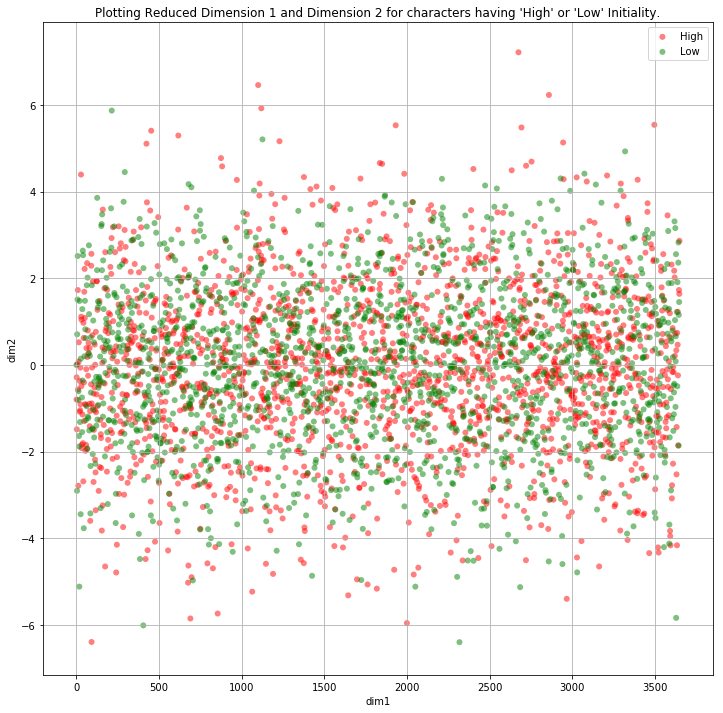

In [89]:
# Main inspiration from:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html

#label_color_pairs=[("High", "red"), ("Low", "green"), ("Intermediate", "blue")]
label_color_pairs=[("High", "red"), ("Low", "green")]

fig, ax = plt.subplots(figsize=(12,12))

for label_color in label_color_pairs:
    x = reduced_df.loc[reduced_df["Init_Cls"] == label_color[0]]["dim1"] 
    y = reduced_df.loc[reduced_df["Init_Cls"] == label_color[0]]["dim2"] 
    
    ax.scatter(x, y, c = label_color[1], label = label_color[0], alpha = 0.5, edgecolors = "none") #the setting of alpha and edgecolor "softens" the dots somewhat, which is preferable in a crowded plot like this

ax.set_xlabel('dim1')
ax.set_ylabel('dim2')
ax.set_title("Plotting Reduced Dimension 1 and Dimension 2 for characters having 'High' or 'Low' Initiality.")
ax.legend()
ax.grid(True)

plt.show()

The scatter plot confirms the correlation. The dimensionality reduced embeddings do not indicate that characters that are more likely to appear at the beginning of a Chinese word are also more similar to one another than characters more likely to appear in the middle or end. 
